# Data Collection

We will collect the data from the Xenium Datasets on the 10x Genomics platform.

In [1]:
import requests

In [2]:
def download_file(url):
    # Get the filename from the URL
    filename = f"data/{url.split('/')[-1]}"

    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the file
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
        print(f"File '{filename}' downloaded successfully.")
    else:
        print(f"Error: Unable to download file. HTTP status code: {response.status_code}")

In [90]:
url = "https://cf.10xgenomics.com/samples/xenium/1.0.2/Xenium_V1_FFPE_Human_Breast_ILC/Xenium_V1_FFPE_Human_Breast_ILC_outs.zip"
download_file(url)

KeyboardInterrupt: 

# Get Data Array

In [3]:
import zipfile

In [4]:

with zipfile.ZipFile('data/Xenium_V1_FFPE_Human_Breast_ILC_outs.zip', 'r') as data:
    data.extractall('data/hBreast')

This should have extracted all the outs. For now, we are interested in the transcripts data.

In [5]:
import pandas as pd
import numpy as np

In [6]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)

In [7]:
# Display the first few rows of the DataFrame
print(df_transcripts.head())

print(len(df_transcripts))

     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
0  281474976710657   191815                 1          LUM   4797.2383   
1  281474976710663   214084                 1       SEC11C   4801.7330   
2  281474976710672   191342                 0         TCIM   4804.4920   
3  281474976710673   191574                 0         STC1   4805.0483   
4  281474976710674   192193                 0         STC1   4805.7170   

   y_location  z_location         qv  error_prob  
0   550.61346   15.421524  18.445875    0.014303  
1   905.11600   14.925031  31.019386    0.000791  
2   596.05396   14.681485  22.270780    0.005928  
3   414.38370   19.306356  16.183300    0.024081  
4   273.81440   16.112896  26.251837    0.002370  
43775350


In [8]:
# Function to read a Parquet file and convert it to a pandas DataFrame
def read_parquet_to_dataframe(file_path):
    """
    Reads a Parquet file from the specified file path and converts it into a pandas DataFrame.

    Parameters:
    file_path (str): The file path of the Parquet file to be read.

    Returns:
    pd.DataFrame: A DataFrame containing the data from the Parquet file.
    """

    # Using pandas to read the Parquet file
    try:
        df = pd.read_parquet(file_path)
        return df
    except Exception as e:
        # If there's an error (e.g., file not found, file format issues), it will print the error message
        print(f"Error reading the Parquet file: {e}")
        return None

In [9]:
file_path = 'data/hBreast/transcripts.parquet' # Replace with your Parquet file path
dataframe = read_parquet_to_dataframe(file_path)

# Optional: Displaying the DataFrame if it's not None
if dataframe is not None:
    print(dataframe)

            transcript_id  cell_id  overlaps_nucleus feature_name  \
0         281474976710657   191815                 1       b'LUM'   
1         281474976710663   214084                 1    b'SEC11C'   
2         281474976710672   191342                 0      b'TCIM'   
3         281474976710673   191574                 0      b'STC1'   
4         281474976710674   192193                 0      b'STC1'   
...                   ...      ...               ...          ...   
43775345  281986078481404   324162                 1  b'SLC25A37'   
43775346  281986078481407   324372                 0      b'NARS'   
43775347  281986078481408   324323                 1  b'ANKRD30A'   
43775348  281986078481409   324493                 1       b'LUM'   
43775349  281986078481411   324387                 1  b'ANKRD30A'   

           x_location   y_location  z_location         qv  
0         4797.238281   550.613464   15.421524  18.445875  
1         4801.732910   905.116028   14.925031  31.

# Convert the dataset s.t. each row is a cell.

In [10]:
location_means = df_transcripts.groupby('cell_id').agg({
    'x_location': 'mean',
    'y_location': 'mean',
    'z_location': 'mean'
}).reset_index()

In [11]:
counts = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
print(counts.head())
counts["normalized_log1p_count"] = np.log1p(counts['count'])

   cell_id feature_name  count
0       -1       ABCC11    212
1       -1        ACTA2   6097
2       -1        ACTG2   1450
3       -1        ADAM9   1732
4       -1       ADGRE5    394


In [12]:
counts_pivot = counts.pivot_table(index='cell_id', 
                                  columns='feature_name', 
                                  values='normalized_log1p_count', 
                                  fill_value=0)

In [13]:
breast_cells_df = location_means.join(counts_pivot, on='cell_id')

In [14]:
print(breast_cells_df.head())
breast_cells_df.shape

   cell_id   x_location   y_location  z_location    ABCC11     ACTA2  \
0       -1  3891.438437  3353.932461   18.408364  5.361292  8.715716   
1        1  1587.163466  1683.353685   15.503466  0.000000  1.098612   
2        2  1650.412715  1514.380829   14.616766  0.000000  0.000000   
3        3  1645.398455  1703.216616   16.257603  0.000000  0.693147   
4        4  1664.134134  1506.358351   14.915675  0.000000  1.386294   

      ACTG2     ADAM9    ADGRE5     ADH1B  ...    TUBA4A    TUBB2B      UCP1  \
0  7.280008  7.457609  5.978886  9.069698  ...  6.714171  5.347108  3.433987   
1  0.000000  0.693147  0.000000  2.302585  ...  0.000000  0.693147  0.000000   
2  0.000000  0.693147  1.098612  0.693147  ...  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4  0.693147  0.000000  0.000000  1.386294  ...  1.609438  0.000000  0.000000   

      USP53     VOPP1       VWF      WARS      ZEB1      ZEB2    ZNF562  
0  7.768956 

(356743, 545)

In [15]:
# Drop the unassigned cell id
breast_cells_df = breast_cells_df.query("cell_id != -1")

In [16]:
print(breast_cells_df.shape)
breast_cells_df.head()

(356742, 545)


,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
1,1,1587.163466,1683.353685,15.503466,0.0,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.0,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.412715,1514.380829,14.616766,0.0,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.0,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.0,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147
5,5,1656.032139,1655.501974,16.797634,0.0,0.000000,0.000000,1.098612,0.000000,1.098612,...,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
breast_cells_df.to_csv("data/hBreast/hBreastST.csv")

# Plotting

We can plot the the locations of the transcripts using a 3D scatterplot (only for AZGP1).

In [18]:
import matplotlib.pyplot as plt

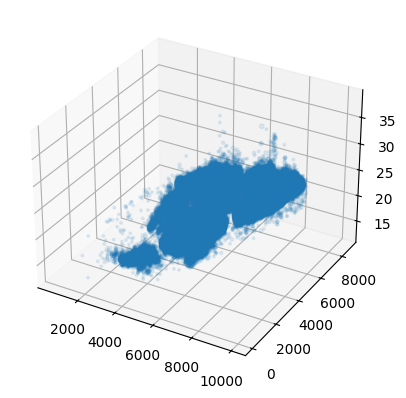

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(breast_cells_df["x_location"], breast_cells_df["y_location"], breast_cells_df["z_location"], s=5*breast_cells_df["ABCC11"], alpha=0.1)

# Clustering

For now, we will use a very trivial clustering technique just to showcase what is possible with the data we have collected so far.

### Clustering with Scanpy

In [20]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

In [21]:
breast_sc_adata = ad.read_csv('data/hBreast/hBreastST.csv')

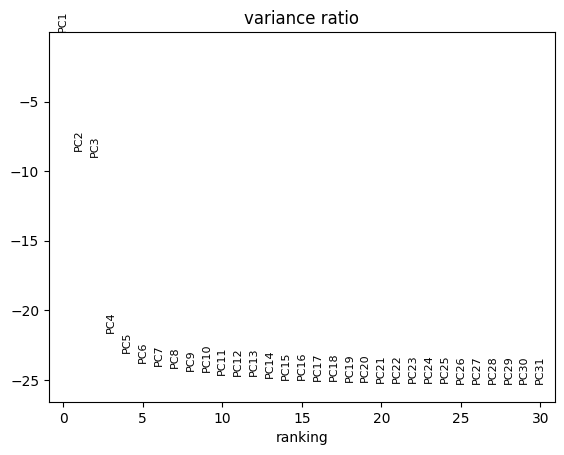

In [22]:
sc.tl.pca(breast_sc_adata, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(breast_sc_adata, log=True)

In [23]:
sc.pp.neighbors(breast_sc_adata, n_neighbors=15, n_pcs=20)

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [24]:
sc.tl.leiden(breast_sc_adata,resolution=2.2,key_added='leiden_2_2')
sc.tl.leiden(breast_sc_adata,resolution=1.8,key_added='leiden_1_8')
sc.tl.leiden(breast_sc_adata,resolution=1.4,key_added='leiden_1_4')
sc.tl.leiden(breast_sc_adata,resolution=1.0,key_added='leiden_1_0')
sc.tl.leiden(breast_sc_adata,resolution=0.8,key_added='leiden_0_8')
sc.tl.leiden(breast_sc_adata,resolution=0.6,key_added='leiden_0_6')
sc.tl.leiden(breast_sc_adata,resolution=0.025,key_added='leiden_0_025')

In [27]:
sc.tl.leiden(breast_sc_adata,resolution=0.001,key_added='leiden_0_001')

In [28]:
sc.tl.umap(breast_sc_adata, min_dist=0.1)

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [30]:
breast_sc_adata.obs['leiden_2_2'], breast_sc_adata.obs['leiden_0_6'], breast_sc_adata.obs['leiden_0_001']

(0         447
 1         447
 2         447
 3         447
 4         447
          ... 
 356737    419
 356738    419
 356739    419
 356740    419
 356741    419
 Name: leiden_2_2, Length: 356742, dtype: category
 Categories (5092, object): ['0', '1', '2', '3', ..., '5088', '5089', '5090', '5091'],
 0          23
 1          23
 2          23
 3          23
 4          23
          ... 
 356737    484
 356738    484
 356739    484
 356740    484
 356741    484
 Name: leiden_0_6, Length: 356742, dtype: category
 Categories (4926, object): ['0', '1', '2', '3', ..., '4922', '4923', '4924', '4925'],
 0          31
 1          31
 2          31
 3          31
 4          31
          ... 
 356737    507
 356738    507
 356739    507
 356740    507
 356741    507
 Name: leiden_0_001, Length: 356742, dtype: category
 Categories (4841, object): ['0', '1', '2', '3', ..., '4837', '4838', '4839', '4840'])

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden_0_001'}, xlabel='UMAP1', ylabel='UMAP2'>

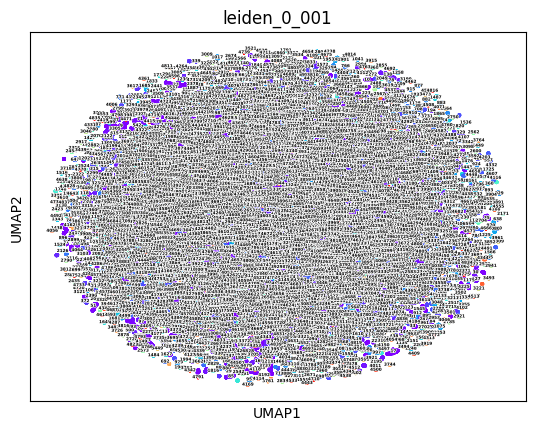

In [31]:
# sc.set_figure_params(scanpy=True, dpi=150,figsize=(10,10))
# plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(breast_sc_adata,size=30,color='leiden_0_001',legend_loc='on data',legend_fontsize=3,legend_fontoutline=1,show=False,palette="rainbow")

### Obviously, this looks way too cluttered. The reason? 